# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: Aidan Fischer
#### Stevens ID: 10447681

## Part A: Multi-Layer Perceptron (MLP) (50 Points)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the data loading, preprocessing, tokenization, and TF-IDF feature extraction.
3. Implement MLP model, evaluation metrics, and Mini-batch GD with AdaGrad.
4. Implement the MLP with Tensorflow and compare to your implementation.
5. Analysis the results in the Conlusion part.

**Before you start**
- Please read the code very carefully.
- Install these packages (jupyterlab, matplotlib, nltk, numpy, scikit-learn, tensorflow, tensorflow_addons, pandas) using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [39]:
# you may not run this cell after the first installation
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [40]:
import tensorflow as tf


tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Processing (5 points)

* Download the dataset from Canvas
* Load data to text and labels
* Preprocessing
* Tokenization
* Split data
* Feature extraction (TF-IDF)

#### Download NLTK stopwords

In [41]:
import os

import nltk


nltk_path = os.path.join('a2-data', 'nltk')
nltk.download('stopwords', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package stopwords to a2-data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
import sys


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    sys.stdout.write(str_ + '\r')
    sys.stdout.flush()

In [43]:
from typing import List, Tuple, Union

import numpy as np

### 1.1 Load data

- Load sentences and labels
- Transform string labels into integers

In [44]:
def load_sentence_label(data_path: str) -> Tuple[List[str], List[str]]:
    """ Load sentences and labels from the specified path
    Args:
        data_path: data_path: path to the data file, e.g., 'a1-data/SMSSpamCollection'
        sentences: the raw text list of all sentences
    Returns:
        labels: the label list of all sentences
    """
    sentences, labels = [], []
    # Start your code here (load text and label from files)
    # Open the data file, loop through each line, and split into label and sentence.
    # Append the label and sentence pair to their appropriate lists.
    with open(data_path, mode="r") as data_file:
        for line in data_file.readlines():
            label, sentence = line.split("\t")
            sentences.append(sentence)
            labels.append(label)
    # End
    return sentences, labels

In [45]:
data_path = os.path.join('a2-data', 'books.txt')
sentences, labels = load_sentence_label(data_path)

label_map = {}
for label in sorted(list(set(labels))):
    label_map[label] = len(label_map)
labels = np.array([label_map[label] for label in labels], dtype=int)
sentences = np.array(sentences, dtype=object)

print('Label map:', label_map)
print('Number of sentences and labels:', len(sentences), len(labels))

Label map: {'Arthur Conan Doyle': 0, 'Fyodor Dostoyevsky': 1, 'Jane Austen': 2}
Number of sentences and labels: 19536 19536


#### Split the data into training, validation and test

In [46]:
def train_test_split(sentences: np.ndarray,
                     labels: np.ndarray,
                     test_ratio: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Split the sentences and labels into training and test data by shuffling
    Args:
        sentences: A numpy array containing all sentences
        labels: A number array containing label ids
        test_ratio: A float number to calculate the number of test data

    Returns:
        train_sentences: A numpy array containing all training sentences
        train_labels: A number array containing all training label ids
        test_sentences: A numpy array containing all test sentences
        test_labels: A number array containing all test label ids
    """
    assert 0 < test_ratio < 1
    assert len(sentences) == len(labels)

    train_index, test_index = [], []
    # Start your code here (split the index for training and test)
    # Create a numpy random number generator, get the number of entries
    # we need for the test set, then randomize a list of the integers from
    # 0 to the length of the data. Take a subset of length "test length"
    # from the shuffled integers, then assign the rest to the train indices
    r = np.random.default_rng(seed=14515)
    length = len(sentences)
    test_n = int(length * test_ratio)
    indices = np.array(range(length))
    r.shuffle(indices)
    train_index = indices[test_n:]
    test_index = indices[:test_n]
    # End

    train_sentences, train_labels = sentences[train_index], labels[train_index]
    test_sentences, test_labels = sentences[test_index], labels[test_index]
    return train_sentences, train_labels, test_sentences, test_labels

In [47]:
np.random.seed(6666)

test_ratio = 0.2
valid_ratio = 0.1
(train_sentences, train_labels,
    test_sentences, test_labels) = train_test_split(sentences, labels, test_ratio)
(train_sentences, train_labels,
    valid_sentences, valid_labels) = train_test_split(train_sentences, train_labels, valid_ratio)

print('Training data length:', len(train_sentences))
print('Validation data length:', len(valid_sentences))
print('Test data length:', len(test_sentences))

Training data length: 14067
Validation data length: 1562
Test data length: 3907


In [48]:
def count_label(labels: np.ndarray, label_map: dict[str, int]) -> dict[str, int]:
    """
    Args:
        labels: The labels of a dataset 
        label_map: The mapping from label to label id
    Returns:
        label_count: The mapping from label to its count
    """
    label_count = {key: 0 for key in label_map.keys()}
    # Start your code here (count the number of each label)
    # Create an inverted map from id to label, then for each label,
    # update the count.
    id_map = {value: key for key, value in label_map.items()}
    for label in labels:
        label_count[id_map[label]] += 1
    # End
    return label_count

In [49]:
print('Training:', count_label(train_labels, label_map))
print('Validation:', count_label(valid_labels, label_map))
print('Test:', count_label(test_labels, label_map))

Training: {'Arthur Conan Doyle': 1869, 'Fyodor Dostoyevsky': 4246, 'Jane Austen': 7952}
Validation: {'Arthur Conan Doyle': 201, 'Fyodor Dostoyevsky': 464, 'Jane Austen': 897}
Test: {'Arthur Conan Doyle': 468, 'Fyodor Dostoyevsky': 1234, 'Jane Austen': 2205}


#### Dataset statistics
Fill this table with the statistics you just printed (double click this cell to edit)

|                | Arthur Conan Doyle | Fyodor Dostoyevsky | Jane Austen | Total |
|:--------------:|--------------------|--------------------|-------------|-------|
|  **Training**  |                1869|                4246|         7952|  14067|
| **Validation** |                 201|                 464|          897|   1562|
|    **Test**    |                 468|                1234|         2205|   3907|
|    **Total**   |                2538|                5944|        11054|  19536|


### 1.2 Preprocess
In this section, you need to remove all the unrelated characters, including punctuation, urls, and numbers. Please fill up the functions and test them by running the following cell.

In [50]:
import re


class Preprocessor:
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number

    def apply(self, sentence: str) -> str:
        """ Apply the preprocessing rules to the sentence
        Args:
            sentence: raw sentence
        Returns:
            sentence: clean sentence
        """
        sentence = sentence.lower()
        if self.url:
            sentence = Preprocessor.remove_url(sentence)
        if self.punctuation:
            sentence = Preprocessor.remove_punctuation(sentence)
        if self.number:
            sentence = Preprocessor.remove_number(sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        return sentence

    @staticmethod
    def remove_punctuation(sentence: str) -> str:
        """ Remove punctuations in sentence with re
        Args:
            sentence: sentence with possible punctuations
        Returns:
            sentence: sentence without punctuations
        """
        # Start your code here
        sentence = re.sub(r'[\.\,\:\;\!\?\(\)]', '', sentence)
        # End
        return sentence

    @staticmethod
    def remove_url(sentence: str) -> str:
        """ Remove urls in text with re
        Args:
            sentence: sentence with possible urls
        Returns:
            sentence: sentence without urls
        """
        # Start your code here
        # Replace urls with a space. The regex here is a complicated regex expression
        # that I built in the past that is generalized and safe (urls of any form, and
        # tries to avoid non-urls that might look like a url)
        
        # See end of this notebook for a breakdown of this regex expression
        sentence = re.sub(r'(?:https?://)?\w+\.\w+(\.\w+?)?(?(1)|(?=/))(?:/\S*?)*(?:[\s]|$|[^\s\w\\\/\&\?\%\#])', "", sentence, flags=re.MULTILINE)
        # End
        return sentence

    @staticmethod
    def remove_number(sentence: str) -> str:
        """ Remove numbers in sentence with re
        Args:
            sentence: sentence with possible numbers
        Returns:
            sentence: sentence without numbers
        """
        # Start your code here
        sentence = re.sub(r'[0-9]', '', sentence)
        # End
        return sentence

##### Test your implementation by running the following cell.

In [51]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{clean_sentence}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"interest rates are trimmed to by the south african central bank but the lack of warning hits the rand and surprises markets"


### 1.3 Tokenization

In [52]:
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords


stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()
print(list(stopwords_set)[:10])

["wouldn't", "she's", 'both', 'each', 'into', 'hasn', 'had', "haven't", 'until', 'which']


In [53]:
def tokenize(sentence: str) -> List[str]:
    """ Tokenize a sentence into tokens (words)
    Args:
        sentence: clean sentence
    Returns:
        tokens
    """
    words = []
    # Start your code here
    #     Step 1. Split sentence into words
    #     Step 2. Extract word stem using the defined stemmer (PorterStemmer) by calling stemmer.stem(word)
    #     Step 3. Remove stop words using the defined stopwords_set
    # Split
    for word in sentence.split(" "):
        # Append stemmed word to words if not part of stopwords
        w = stemmer.stem(word)
        if w not in stopwords_set:
            words.append(w)
    # End
    return words

##### Test your implementation by running the following block.

In [54]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)
tokens = tokenize(clean_sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{tokens}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"['interest', 'rate', 'trim', 'south', 'african', 'central', 'bank', 'lack', 'warn', 'hit', 'rand', 'surpris', 'market']"


### 1.5 Feature Extraction

TF-IDF:
$$\text{TF-IDF}(t, d) = \frac{f_{t, d}}{\sum_{t'}{f_{t', d}}} \times \log{\frac{N}{n_t}}$$

- $t$: A term
- $d$: A document. Here, we regard a sentence as a document
- $f_{t, d}$: Number of term $t$ in $d$
- $N$: Number of document
- $n_t$: Number of document containing $t$

In [55]:
from collections import defaultdict


class TfIdfEncoder:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token2index = {}
        self.df = defaultdict(int)
        self.num_doc = 0
        self.processor = Preprocessor()

    def fit(self, sentences: Union[List[str], np.ndarray]) -> int:
        """ Using the given texts to store key information in TF-IDF calculation
            In this function, you are required to implement the fitting process.
                1. Construct the vocabulary and store the frequency of tokens (self.vocab).
                2. Construct the document frequency map to tokens (self.df).
                3. Construct the token to index map based on the frequency.
                   The token with a higher frequency has the smaller index
        Args:
            sentences: Raw sentences
        Returns:
            token_num
        """
        self.num_doc = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == len(sentences) - 1:
                print_line('Fitting TF-IDF encoder:', (i + 1), '/', len(sentences))
            # Start your code here (step 1 & 2)
            # Get set of unique tokens in the sentence
            # Add to the vocab the number of times that token appears in the sentence
            # Add one to the document frequency for that token
            for token in set(sentence):
                self.vocab[token] += sentence.count(token)
                self.df[token] += 1
            # End
        print_line('\n')
        # Start your code here (Step 3)
        # Split vocab into a list of (token, frequency) pairs, sort that list by the frequency
        # enumerate it to get the indices, then build token2index using that information
        self.token2index = {token: index for index, (token, _) in 
                            enumerate(sorted(list(self.vocab.items()), key=lambda kv: kv[1], reverse=True
                            ))}
        # End
        token_num = len(self.token2index) 
        print('The number of distinct tokens:', token_num)
        return token_num

    def encode(self, sentences: Union[List[str], np.ndarray]) -> np.ndarray:
        """ Encode the sentences into TF-IDF feature vector
            Note: if a token in a sentence does not exist in the fit encoder, we just ignore it.
        Args:
            sentences: Raw sentences
        Returns:
            features: A (n x token_num) matrix, where n is the number of sentences
        """
        n = len(sentences)
        features = np.zeros((n, len(self.token2index)))
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with TF-IDF encoder:', (i + 1), '/', n)
            # Start your code (calculate TF-IDF)
            # For each unique token that exists in the sentence
            # ignore the token if it isn't in the vocab, then get the proper
            # index from token2index. Calculate the TF-IDF for the (token, doc) 
            # pair and put that into the features matrix
            for token in set(sentence):
                if token in self.vocab:
                    index = self.token2index[token]
                    features[i, index] = sentence.count(token) / len(sentence) * np.log(n / self.df[token])
            # End
        print_line('\n')
        return features

##### Test your implementation by running the following cell.

In [56]:
encoder = TfIdfEncoder()
encoder.fit(train_sentences[:100])
features = encoder.encode(train_sentences[:10])

print(features[:5])

Fitting TF-IDF encoder: 100 / 100
The number of distinct tokens: 72
Encoding with TF-IDF encoder: 10 / 10
[[-0.40295239 -0.17194011 -0.22823824 -0.05680315 -0.20059679 -0.02800887
  -0.08597005 -0.11411912 -0.08481612 -0.19698803 -0.02827204 -0.08239592
  -0.02814115  0.          0.         -0.08069108 -0.02760343 -0.02746531
  -0.02689703 -0.05408308 -0.0266029  -0.02599302 -0.05548009 -0.02567655
  -0.0221869   0.         -0.04306916 -0.01986544  0.         -0.02878231
   0.          0.          0.          0.          0.          0.
   0.         -0.01492403  0.          0.          0.          0.
   0.          0.          0.          0.         -0.00985572  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.40988426 -0.2040476  -0.13742093 -0.11895947 -0.

#### Encode training, validation, and test dataset

In [57]:
num_class = 3

encoder = TfIdfEncoder()
vocab_size = encoder.fit(train_sentences)

x_train = encoder.encode(train_sentences)
x_valid = encoder.encode(valid_sentences)
x_test = encoder.encode(test_sentences)

y_train = np.zeros((len(train_labels), num_class))
y_valid = np.zeros((len(valid_labels), num_class))
y_test = np.zeros((len(test_labels), num_class))
y_train[np.arange(len(train_labels)), train_labels] = 1
y_valid[np.arange(len(valid_labels)), valid_labels] = 1
y_test[np.arange(len(test_labels)), test_labels] = 1

print('The size of training set:', x_train.shape, y_train.shape)
print('The size of validation set:', x_valid.shape, y_valid.shape)
print('The size of test set:', x_test.shape, y_test.shape)

Fitting TF-IDF encoder: 14067 / 14067
The number of distinct tokens: 99
Encoding with TF-IDF encoder: 14067 / 14067
Encoding with TF-IDF encoder: 1562 / 1562
Encoding with TF-IDF encoder: 3907 / 3907
The size of training set: (14067, 99) (14067, 3)
The size of validation set: (1562, 99) (1562, 3)
The size of test set: (3907, 99) (3907, 3)


## 2. MLP (20 Points)
In this section, you are required to implement a two-layer MLP model (input -> hidden layer -> output layer) with $L_2$ regularization from scratch. 

The objective function of LR for multi-class classification:

$$J = L(\mathbf{x}, \mathbf{y} \mid \mathbf{w}, \mathbf{b}) = -\frac{1}{n}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}log\frac{e^{f_k}}{\sum_{c=1}^{K}e^{f_c}} + \lambda \sum_{j=1}^{d}w_{kj}^2$$

- $z_1 = w_1x$
- $h_1 = activation(z_1)$
- $z_2 = w_2 h_1$
- $\hat{y} = softmax(z_2)$

- $n$: Number of samples
- $d$: Dimension of $\mathbf{w}$
- Here, you can use `sigmoid` as the activation function for the hidden layer.

### 2.1 MLP Model (5 Points)

In [58]:
def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    """ The softmax activation function
    Args:
        x: Input matrix or vector
        axis: The dimension of x that needs to run softmax, default -1, i.e., the last dimension
    Returns:
        output: Softmax value of the specified dimension in x
    """
    # Start your code here
    # Get the exponential of x, sum across axis, then divide by the sum
    x = np.exp(x)
    exp_sum = np.sum(x, axis=axis, keepdims=True)
    x /= exp_sum
    # End
    return x


def sigmoid(x: np.ndarray) -> np.ndarray:
    """ The sigmoid activation function
    Args:
        x: Input matrix or vector
    Returns:
        output: Sigmoid value of each entry in x
    """
    # Start your code here
    # sigmoid = 1/(1+e^(-x))
    x = 1 / (1 + np.exp(-x))
    # End
    return x

In [59]:

class MLP:
    def __init__(self, feature_dim: int, hidden_dim: int, num_class: int, lambda_: float):
        """ MLP Model
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        # Start your code here (initialize weight and bias)
        # Initialize an rng object, then use Glorot-Bengio normalized weight initialization
        r = np.random.default_rng(seed=6666)
        self.w1 = r.uniform(low=-np.sqrt(6 / (feature_dim + hidden_dim)), 
                            high=np.sqrt(6 / (feature_dim + hidden_dim)),
                            size=(feature_dim, hidden_dim))
        self.b1 = r.uniform(low=-np.sqrt(6 / (1 + hidden_dim)),
                            high=np.sqrt(6 / (1 + hidden_dim)),
                            size=(1, hidden_dim))
        self.w2 = r.uniform(low=-np.sqrt(6 / (hidden_dim + num_class)), 
                            high=np.sqrt(6 / (hidden_dim + num_class)),
                            size=(hidden_dim, num_class))
        self.b2 = r.uniform(low=-np.sqrt(6 / (1 + num_class)), 
                            high=np.sqrt(6 / (1 + num_class)),
                            size=(1, num_class))

        # End
        self.lambda_ = lambda_
        self.eps = 1e-9

    def forward(self, x: np.ndarray, return_hiddens: bool = False) -> np.ndarray:
        """ Forward process of logistic regression
            Calculate y_hat using x
        Args:
            x: Input data
            return_hiddens: If true the function will return h1 for gradient calculation
        Returns:
            y_hat: Output
            h1: Hidden output, used for gradient calculation. Returned if return_hiddens is set to True
        """
        y_hat = 0
        h1 = 0, 0
        w1, b1, w2, b2 = self.w1, self.b1, self.w2, self.b2
        # Start your code here (calculate y_hat of MLP using x)
        z1 = x @ w1 + b1
        h1 = sigmoid(z1)
        z2 = h1 @ w2 + b2
        y_hat = softmax(z2)
        # End
        if return_hiddens:
            return y_hat, h1
        else:
            return y_hat

    def backward(self,
                 x: np.ndarray,
                 y_hat: np.ndarray,
                 y: np.ndarray,
                 h1: np.array) -> Tuple[np.ndarray, Union[float, np.ndarray], np.ndarray, Union[float, np.ndarray]]:
        """ Backward process of logistic regression
            Calculate the gradient of w and b
        Args:
            x: Input data
            y_hat: Output of forward
            y: Ground-truth
            h1: Hidden output of the hidden layer
        Returns:
            dw1: Gradient of w1
            db1: Gradient of b1
            dw2: Gradient of w2
            db2: Gradient of b2
        """
        w1, w2 = self.w1, self.w2
        dw1, db1, dw2, db2 = 0.0, 0.0, 0.0, 0.0
        n = len(x)
        # Start your code here (calculate the gradient of w and b)
        # dw2 = ∂J/∂w2 = ∂J/∂y_hat * ∂y_hat/∂w2 + 2 lambda w2 
        # = ∂J/∂y_hat * ∂y_hat/∂z2 * ∂z2/∂w2
        # Derivative of j with respect to y_hat = -1/n * sum(y / yhat)
        # because d/dyhat (log(yhat)) = 1/yhat
        djyhat = -1 / n * y / y_hat
        # Derivate of yhat with respect to z2 is the derivative of the softmax function
        # = d/dz2 (e^z2/sum(e^z2)) = (e^z2sum(e^z2)-e^2z2))/(sum(e^z2)^2)
        # = (e^z2sum(e^z2))/(sum(e^z2)^2)-e^2z2/(sum(e^z2)^2))
        # = e^z2/sum(e^z2)-(e^z2/sum(e^z2))^2
        # = y_hat-y_hat^2 = y_hat (1-y_hat)
        dyhatz2 = y_hat * (1 - y_hat)
        # Derivative of z2 with respect to w2 = h1
        dz2w2 = h1
        dw2 = ((djyhat * dyhatz2).T @ dz2w2).T + 2 * w2 ** 2
        
        # db2 = ∂J/∂b2 = ∂J/∂yhat * ∂yhat/∂z2 * ∂z2/∂b2
        # Derivative of z2 with respect to b2 is [1...]
        dz2b2 = np.ones_like(self.b2)
        db2 = ((djyhat.T @ dyhatz2) @ dz2b2.T).T
        
        # dw1 = ∂J/∂w1 = ∂J/∂y_hat * ∂y_hat/∂z2 * ∂z2/∂h1 * ∂h1/∂z1 * ∂z1/∂w1
        dz2h1 = w2.T
        # Similarly to softmax, sigmoid's derivative can be written in terms of the 
        # original function
        dh1z1 = h1 * (1 - h1)
        dz1w1 = x
        dw1 = (((dyhatz2 @ dz2h1) * dh1z1).T @ dz1w1).T
        
        # db1 = ∂J/∂b1 = ∂J/∂y_hat * ∂y_hat/∂z2 * ∂z2/∂h1 * ∂h1/∂z1 * ∂z1/b1
        # ∂z1/b1 = [1...]
        dz1b1 = np.ones_like(self.b1)
        db1 = ((dyhatz2 @ dz2h1).T @ dh1z1 @ dz1b1.T).T
        
        # End
        return dw1, db1, dw2, db2

    def categorical_cross_entropy_loss(self,
                                       y_hat: np.ndarray,
                                       y: np.ndarray) -> Union[float, np.ndarray]:
        """ Calculate the binary cross-entropy loss
        Args:
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            loss: BCE loss
        """
        y_hat = np.clip(y_hat, a_min=self.eps, a_max=1 - self.eps)
        loss = 0
        # Start your code here (Calculate the binary cross-entropy)
        # Apply BCE with L2 regularization. It seems the weights are added 
        # for each input, so over all inputs n copies of the weights are added
        # then divided by n and multiplied by -1 so overall a single copy is 
        # subtracted. The sum bounds (K=number of class by d = weight dimension)
        # implies w2 rather than w1
        loss = -1 / len(y) * np.sum(y * np.log(y_hat)) + self.lambda_ * np.sum(self.w2 ** 2)
        # End
        return loss

    def gradient_descent(self, dw1: np.ndarray, db1: Union[np.ndarray, float], dw2: np.ndarray, db2: Union[np.ndarray, float], lr: float):
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        self.w2 -= lr * dw2
        self.b2 -= lr * db2

    def predict(self, y_hat: np.ndarray) -> np.ndarray:
        """ Predict the label using the output y_hat
        Args:
            y_hat: Model output
        Returns:
            pred: Prediction
        """
        pred = np.zeros_like(y_hat)
        index = np.argmax(y_hat, axis=-1)
        pred[np.arange(len(y_hat)), index] = 1
        return pred

### 2.2 Evaluation Metrics

Accuracy, Precision, Recall, F1

In [60]:
from sklearn.metrics import precision_recall_fscore_support


def get_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    """ Calculate the accuracy, precision, recall, and f1 score.
        You are allowed to use precision_recall_fscore_support from scikit-learn. Please set average to 'micro'
    Args:
        y_pred: Prediction
        y_true: Ground-truth
    Returns:
        accuracy: float number. The accuracy for the whole dataset
        precision, recall, f1: np.ndarray (num_class, ). The precision, recall, f1 for each class
    """
    assert y_pred.shape == y_true.shape
    accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
    # Start your code here
    # Use sklearn to get precision, recall, fscore for each class
    # the docstring above says to set average to micro, but everything else (returns description, 
    # typehint) indicates we want average=None here... So I just set average=None. 
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0.0)
    # Accuracy is correct/total
    accuracy = np.sum(y_true == y_pred) / np.size(y_true)
    # End
    return accuracy, precision, recall, f1

### 2.3 AdaGrad (5 points)

$$ \mathbf{G}^{(t + 1)} \leftarrow \mathbf{G}^{(t)} + \boldsymbol{g}^{(t + 1)} \cdot \boldsymbol{g}^{(t + 1)} $$
$$ \mathbf{w}^{(t + 1)} \leftarrow \mathbf{w}^{(t)} - \frac{\eta}{\sqrt{\mathbf{G}^{(t + 1)} + \epsilon}}\boldsymbol{g}^{(t + 1)} = \mathbf{w}^{(t)} - \eta\frac{\boldsymbol{g}^{(t + 1)}}{\sqrt{\mathbf{G}^{(t + 1)} + \epsilon}} $$

In [61]:
class AdaGrad:
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model
        
        self.accumulative_dw1 = 0
        self.accumulative_db1 = 0
        self.accumulative_dw2 = 0
        self.accumulative_db2 = 0
        self.eps = 1e-9
        
    def update(self, dw1: np.ndarray, db1: Union[np.ndarray, float], dw2: np.ndarray, db2: Union[np.ndarray, float]):
        """ 1. Use the gradient in the current step to update the accumulative gradient of each parameter.
            2. Calculate the new gradient with the accumulative gradient
            3. Use the init learning rate the new gradient to update the parameter with model.gradient_descent()
        
        Do not return anything
        """
        # Start your code here
        # Step 1
        self.accumulative_dw1 += dw1 ** 2
        self.accumulative_db1 += db1 ** 2
        self.accumulative_dw2 += dw2 ** 2
        self.accumulative_db2 += db2 ** 2
        # Step 2
        ndw1 = dw1 / np.sqrt(self.accumulative_dw1 + self.eps)
        ndb1 = db1 / np.sqrt(self.accumulative_db1 + self.eps)
        ndw2 = dw2 / np.sqrt(self.accumulative_dw2 + self.eps)
        ndb2 = db2 / np.sqrt(self.accumulative_db2 + self.eps)
        # Step 3
        self.model.gradient_descent(ndw1, ndb1, ndw2, ndb2, self.init_lr)
        # End

        

### 2.4 Mini-batch Gradient Descent (5 Points)

In [62]:

from collections import OrderedDict


def train_mbgd(model: 'MLP',
               x_train: np.ndarray,
               y_train: np.ndarray,
               x_valid: np.ndarray,
               y_valid: np.ndarray,
               lr: float,
               num_epoch: int,
               batch_size: int,
               print_every: int = 10) -> Tuple[dict[str, List], dict[str, List]]:
    """ Training with Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        batch_size: Number of training samples in a batch
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of training and validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {(val[-1]):.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {(val[-1]):.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    # IMPORTANT: YOU SHOULD USE THIS OPTIMIZER TO UPDATE THE MODEL
    optimizer = AdaGrad(init_lr=lr, model=model)

    train_num_samples = len(x_train)
    n_batch = train_num_samples // batch_size
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        # Start your code here (training)
        #     Step 1. Model forward
        #     Step 2. Calculate loss
        #     Step 3. Model backward
        #     Step 4. Optimization with Adagrad
        # Get batches using np.array_split
        for batch_x, batch_y in zip(np.array_split(x_train, n_batch, axis=0),
                                    np.array_split(y_train, n_batch, axis=0)):
            # Model forward with return hiddens
            y_hat, h1 = model.forward(batch_x, True)
            # Get the loss
            epoch_loss = model.categorical_cross_entropy_loss(y_hat, batch_y)
            # Backpropogation
            dw1, db1, dw2, db2 = model.backward(batch_x, y_hat, batch_y, h1)
            # Optimize
            optimizer.update(dw1, db1, dw2, db2)
            
        # End

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        # Start your code here (validation)
        #     Step 1. Predict
        #     Step 2. Calculate loss
        #     Step 3. Calculate metrics
        y_hat = model.forward(x_valid)
        valid_loss = model.categorical_cross_entropy_loss(y_hat, y_valid)
        accuracy, precision, recall, f1 = get_metrics(model.predict(y_hat), y_valid)
        # End

        train_history['loss'].append(epoch_loss / train_num_samples)
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history

Run Mini-batch Gradient Descent

In [63]:
np.random.seed(6666)

hidden_dim = 128
num_epoch = 100
lr = 1e-2
batch_size = 128
lambda_ = 1e-8
print_every = 10

model_mbgd = MLP(feature_dim=vocab_size, hidden_dim=hidden_dim, num_class=num_class, lambda_=lambda_)
mbgd_train_history, mbgd_valid_history = train_mbgd(model_mbgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, batch_size, print_every)

Epoch 1 / 100: train_loss: 0.0001 - valid_loss: 1.1941 - valid_accuracy: 0.7162 - valid_precision: 0.5743 - valid_recall: 0.5743 - valid_f1: 0.5743
Epoch 11 / 100: train_loss: 0.0001 - valid_loss: 2.0932 - valid_accuracy: 0.7162 - valid_precision: 0.5743 - valid_recall: 0.5743 - valid_f1: 0.5743
Epoch 21 / 100: train_loss: 0.0001 - valid_loss: 2.5287 - valid_accuracy: 0.7162 - valid_precision: 0.5743 - valid_recall: 0.5743 - valid_f1: 0.5743
Epoch 31 / 100: train_loss: 0.0001 - valid_loss: 2.8906 - valid_accuracy: 0.7157 - valid_precision: 0.5736 - valid_recall: 0.5736 - valid_f1: 0.5736
Epoch 41 / 100: train_loss: 0.0001 - valid_loss: 3.2058 - valid_accuracy: 0.7157 - valid_precision: 0.5736 - valid_recall: 0.5736 - valid_f1: 0.5736
Epoch 51 / 100: train_loss: 0.0001 - valid_loss: 3.4024 - valid_accuracy: 0.7157 - valid_precision: 0.5736 - valid_recall: 0.5736 - valid_f1: 0.5736
Epoch 61 / 100: train_loss: 0.0001 - valid_loss: 3.4507 - valid_accuracy: 0.7157 - valid_precision: 0.5736 

### 2.5 MLP using Tensorflow (5 Points)

In [64]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.activations import sigmoid


class MLPTF(Model):
    def __init__(self, feature_dim: int, hidden_dim: int, num_class: int, lambda_: float):
        """ MLP Model using tensorflow.keras
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        super().__init__()
        # Start your code here (initialize weight and bias)
        self.dense1 = Dense(hidden_dim, activation=sigmoid, use_bias=True)
        self.dense2 = Dense(num_class, activation=tf.keras.activations.linear, use_bias=True)
        self.softmax = Softmax()

        # End
        
    def call(self, x):
        """ Forward function of tf. It should be named 'call'
        
        Args:
            x: (n x feature_dim) tensor
        Returns:
            y_hat: (n x num_class) tensor
        """
        # Start your code here (Forward)
        y_hat = self.softmax(self.dense2(self.dense1(x)))
        # End
        return y_hat

In [65]:
import tensorflow_addons as tfa
np.random.seed(6666)
tf.random.set_seed(6666)


hidden_dim = 128
num_epoch = 100
lr = 1e-1
batch_size = 128
lambda_ = 1e-8

model_tf = MLPTF(feature_dim=vocab_size, hidden_dim=hidden_dim, num_class=num_class, lambda_=lambda_)
model_tf.build(input_shape=(None, vocab_size))
model_tf.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=num_class, average='micro')])
model_tf.summary()

/home/aidan/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "mlptf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  12800     
                                                                 
 dense_1 (Dense)             multiple                  387       
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 13187 (51.51 KB)
Trainable params: 13187 (51.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-03-04 22:27:04.735639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 22:27:04.735821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 22:27:04.735866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 22:27:04.912238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 22:27:04.912317: I external/local_xla/xla/stream_executor

In [66]:
tf_history = model_tf.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=num_epoch)

Epoch 1/100


2024-03-04 22:27:07.326646: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-04 22:27:07.567896: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb8943330b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-04 22:27:07.567952: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-03-04 22:27:07.596979: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-04 22:27:07.668946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709609227.737561    5476 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 [==============================] - 3s 10ms/step - loss: 1.0204 - categorical_accuracy: 0.5286 - f1_score: 0.5286 - val_loss: 0.9444 - val_categorical_accuracy: 0.5743 - val_f1_score: 0.5743
Epoch 2/100
110/110 [==============================] - 1s 9ms/step - loss: 0.9712 - categorical_accuracy: 0.5604 - f1_score: 0.5604 - val_loss: 0.9608 - val_categorical_accuracy: 0.5743 - val_f1_score: 0.5743
Epoch 3/100
110/110 [==============================] - 1s 10ms/step - loss: 0.9605 - categorical_accuracy: 0.5602 - f1_score: 0.5602 - val_loss: 0.9443 - val_categorical_accuracy: 0.5743 - val_f1_score: 0.5743
Epoch 4/100
110/110 [==============================] - 1s 9ms/step - loss: 0.9623 - categorical_accuracy: 0.5653 - f1_score: 0.5653 - val_loss: 0.9556 - val_categorical_accuracy: 0.5743 - val_f1_score: 0.5743
Epoch 5/100
110/110 [==============================] - 1s 9ms/step - loss: 0.9553 - categorical_accuracy: 0.5653 - f1_score: 0.5653 - val_loss: 0.9500 - val_categorical_accur

#### Evaluation with Tensroflow
You are required to report the loss, accuracy, precision, recall, and f1 on test set and plot the the curve of them for both SGD and Mini-batch GD on train and validation set

In [67]:
# Calculate the metrics for test set and fill in the table below
y_hat = model_mbgd.forward(x_test)
y_pred = model_mbgd.predict(y_hat)
print('Mini-batch GD:', get_metrics(y_pred, y_test))
model_tf.evaluate(x=x_test, y=y_test)

Mini-batch GD: (0.7087279242385462, 0.5630918863578193, 0.5630918863578193, 0.5630918863578193)
123/123 [==============================] - 1s 8ms/step - loss: 0.9404 - categorical_accuracy: 0.5631 - f1_score: 0.5631


[0.9403693079948425, 0.5630918741226196, 0.5630918741226196]

#### Evaluation Metrics on Test set
Fill this table with the result you just printed (double click this cell to edit)
|     Optimizer                     | Accuracy    | F1 Score    |
|:---------------------------------:|-------------|-------------|
|      **Your Implementation**      |       0.5631|       0.5631|
| **Tensorflow**                    |       0.5631|       0.5631|

##### Please run the following cell to plot the training loss curve for Your implementation and Tensorflow

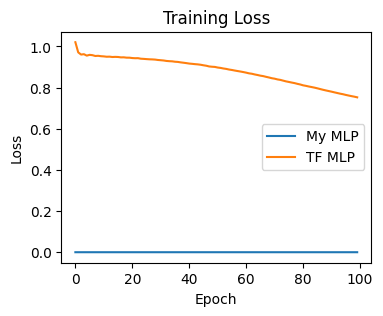

In [68]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(4, 3))
plt.plot(mbgd_train_history['loss'], label='My MLP')
plt.plot(tf_history.history['loss'], label='TF MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

##### Please run the following cell to plot the validation metrics curve for SGD and Mini-batch GD

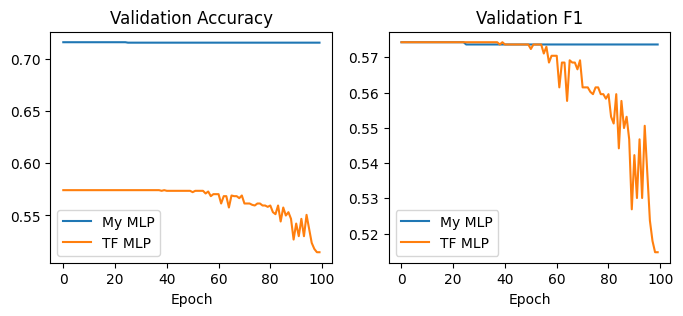

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
ax = axes[0]
ax.plot(mbgd_valid_history['accuracy'], label='My MLP')
ax.plot(tf_history.history['val_categorical_accuracy'], label='TF MLP')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('Validation Accuracy')

ax = axes[1]
ax.plot(mbgd_valid_history['f1'], label='My MLP')
ax.plot(tf_history.history['val_f1_score'], label='TF MLP')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('Validation F1')
plt.show()

# 3. Conclusion (5 Points)

Provide an analysis for all the results

Answer: Both my manually programmed model and tensorflow's model result in similar validation metrics, though neither improved over time and the validation metrics weren't very impressive. 

Normally, I would suspect I did something wrong with my derivatives, but since tensorflow also didn't perform very well, I'm not entirely sure that I *did* mess up. 

As for the graphs, my training error looks to be really small, but I think that's a matter of scaling.

Validation error does increase over time for my model, but I'm not sure why. In addition, both validation accuracy and f1 *decrease* over time for the tensorflow model.

Breakdown of the regex used to remove URLs in preprocessing code

    (?:https?://)?\w+\.\w+(\.\w+?)?(?(1)|(?=/))(?:/\S*?)*(?:[\s]|$|[^\s\w\\\/\&\?\%\#])

    (?:https?://)? - Matches http or https, if present, but not required to match a link.

    (i.e. https://www... or http://www... or just www...)
    \w+\.\w+(\.\w+?)? - Matches 3 group or 2 group link methods (i.e. www.abc.xyz or just abc.xyz)

    (?(1)|(?=/)) - Ensures that if the previous part matches a 2 group, that the link is followed by a forward slash (/). This is to
    prevent matching a link on sentences not followed by spaces (i.e preventing blah blah blah.blah blah) from matching blah.blah

    (?:/\S*?)* - matches any number of /... segments, allows link to end in forward slash. (i.e. www.abc.xyz/abc/)

    (?:[\s]|$|[^\s\w\\\/\&\?\%\#]) - Terminates the match if a whitespace character, string end, or a non-whitespace charater that isn't 
    generally part of urls is encountered, and forces previous lazy matching
    
    (+? and *?, which match as little as possible) to consume the entire link, but not beyond the link.